<a href="https://colab.research.google.com/github/Asfilcnx3/Project7_CIFAR10/blob/main/CIFAR-10_project7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Now we will do a Classification Report on the CIFAR-10 dataset with 32x32 size and RGB scale images.
* We will use a deepest CNN.

In [14]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torch import nn, optim
import torch.nn.functional as F
from keras.datasets import cifar10
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Estas usando: cuda


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


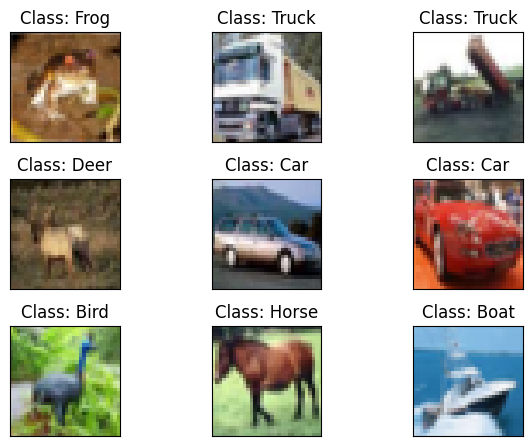

In [7]:
# To visualize the working data we need to load from keras
# To work with the data we will load from torchvision

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

labels = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Boat", "Truck"]
y = y_train.reshape(-1)

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.tight_layout()
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.title(f"Class: {labels[y_train[i][0]]}")
plt.show()

In [8]:
# Creating the transforms
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
full_test_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)

# Manual Split
train_size = int(0.8 * len(full_train_data)) # 40,000
test_size = int(0.1 * len(full_train_data)) # 5,000
valid_size = int(0.1 * len(full_train_data)) # 5,000

train_data, _, _ = random_split(full_train_data, [train_size, test_size, valid_size])
_, valid_data, test_data = random_split(full_test_data, [train_size, test_size, valid_size])

# Using batch_size with DataLoader
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(valid_data)}")
print(f"Test size: {len(test_data)}")

Tamaño del conjunto de Entrenamiento: 40000
Tamaño del conjunto de Validación: 5000
Tamaño del conjunto de Prueba: 5000


## The arquitecture of the CNN will be:

* `Conv2D -> MaxPool -> Conv2D -> MaxPool -> Conv2D -> MaxPool -> Dropout -> Flatten -> Dense -> Dense`

Epoch: 1/100, Train Loss: 1.5096, Val Loss: 1.2088, Val Acc: 56.00%
--------------------------------------------------
Epoch: 2/100, Train Loss: 1.2144, Val Loss: 1.0269, Val Acc: 62.30%
--------------------------------------------------
Epoch: 3/100, Train Loss: 1.0965, Val Loss: 0.9177, Val Acc: 66.80%
--------------------------------------------------
Epoch: 4/100, Train Loss: 1.0178, Val Loss: 0.7927, Val Acc: 71.82%
--------------------------------------------------
Epoch: 5/100, Train Loss: 0.9568, Val Loss: 0.7766, Val Acc: 72.48%
--------------------------------------------------
Epoch: 6/100, Train Loss: 0.9086, Val Loss: 0.7295, Val Acc: 75.02%
--------------------------------------------------
Epoch: 7/100, Train Loss: 0.8735, Val Loss: 0.6965, Val Acc: 75.86%
--------------------------------------------------
Epoch: 8/100, Train Loss: 0.8432, Val Loss: 0.6470, Val Acc: 77.58%
--------------------------------------------------
Epoch: 9/100, Train Loss: 0.8161, Val Loss: 0.63

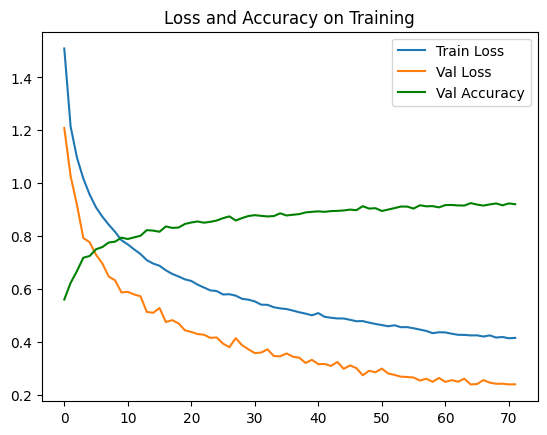

In [11]:
# Create the CNN
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32) # Add batch normalization
    self.pool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2, 2)

    self.dropout = nn.Dropout(0.3)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128 * 4 * 4, 256)
    self.dropout2 = nn.Dropout(0.3) # double dropout layer
    self.out = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool1(x)

    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool2(x)

    x = F.relu(self.bn3(self.conv3(x)))
    x = self.pool3(x)

    x = self.dropout(x)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    return self.out(x)

# Params
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

## Training Loop
epochs = 100
best_val_loss = float('inf')
patience = 7
counter = 0

train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  model.train()
  running_loss = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_losses.append(running_loss / len(train_loader))

  model.eval()
  val_loss = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = loss_fn(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  acc = accuracy_score(all_labels, all_preds)
  val_losses.append(val_loss / len(valid_loader))
  val_accs.append(acc)

  print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")
  print("-----" * 10)

  if val_losses[-1] < best_val_loss:
    best_val_loss = val_losses[-1]
    counter = 0
    torch.save(model.state_dict(), "cifar10_best_model.pt")
  else:
    counter += 1
    if counter >= patience:
      print(f"Early stopping activated on: {epoch+1}")
      break


# Visualizando el entrenamiento
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accs, label="Val Accuracy", color='green')
plt.title("Loss and Accuracy on Training")
plt.legend()
plt.show()

Accuracy: 92.3200%
--------------------------------------------------


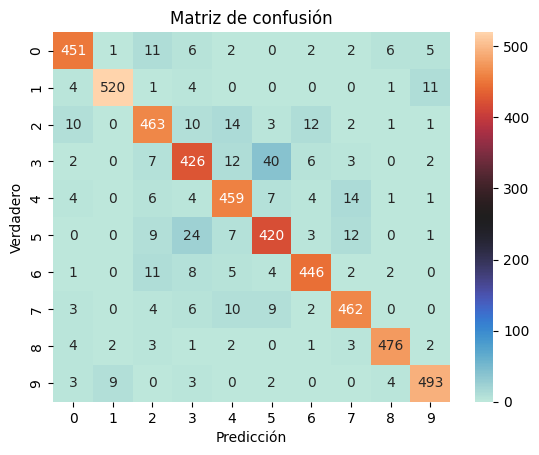

--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       486
           1       0.98      0.96      0.97       541
           2       0.90      0.90      0.90       516
           3       0.87      0.86      0.86       498
           4       0.90      0.92      0.91       500
           5       0.87      0.88      0.87       476
           6       0.94      0.93      0.93       479
           7       0.92      0.93      0.93       496
           8       0.97      0.96      0.97       494
           9       0.96      0.96      0.96       514

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



In [17]:
# Evaluando con los el set de Prueba
all_preds = []
all_labels = []
model = CNN().to(device)
model.load_state_dict(torch.load("cifar10_best_model.pt"))
model.eval()


with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {acc*100:.4f}%')
print("-----" * 10)

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="icefire")
plt.title("Confussion Matriz")
plt.xlabel("Prediction")
plt.ylabel("True")
plt.show()

print("-----" * 10)
print("Classification report:")
print(classification_report(all_labels, all_preds))